# ELECTRA Fine-Tuned

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('train.csv')
data[2010:].head(10)

,id,keyword,location,text,target
2010,2886,damage,NaN,Beach did damage to my shit,1
2011,2887,damage,NaN,@WonderousAllure crosses her arms to cover her...,0
2012,2888,damage,NaN,New post on my blog: http://t.co/Avu9b4k2rv \n...,0
2013,2889,damage,Charlotte NC,REPORTED: HIT &amp; RUN-IN ROADWAY-PROPERTY DA...,1
2014,2890,damage,NaN,Devil May Cry 4 Special Edition Vergil Vs Agnu...,0
2015,2891,damage,"Rockville, Maryland",#Glaucoma occurs when fluid builds up pressure...,1
2016,2893,damage,NaN,#JSunNews Storm damage reported in Madison Cou...,1
2017,2895,damage,NaN,S61.231A Puncture wound without foreign body o...,1
2018,2896,damage,Australia,Thank you @RicharkKirkArch @AusInstArchitect f...,0
2019,2898,damage,Your Conversation,This real shit will damage a bitch,0


In [2]:
data['text'] = data['text'].str.replace('http\S+', 'http', regex=True)  # replace all URLs with "http"
data['text'] = data['text'].str.replace('&\S+', '', regex=True)  # remove all html junks
data['text'] = data['text'].str.replace('[0-9]','0', regex=True)  # replace all integer valeus with 0
data['text'] = data['text'].str.replace('[^a-zA-Z0 ]', '', regex=True)
data['text'] = data['text'].str.lower()

data = data.drop(labels=['keyword', 'location'], axis=1)
data[2010:].head(10)

,id,text,target
2010,2886,beach did damage to my shit,1
2011,2887,wonderousallure crosses her arms to cover her ...,0
2012,2888,new post on my blog http thesensualeyemodel ca...,0
2013,2889,reported hit runin roadwayproperty damage at ...,1
2014,2890,devil may cry 0 special edition vergil vs agnu...,0
2015,2891,glaucoma occurs when fluid builds up pressure ...,1
2016,2893,jsunnews storm damage reported in madison coun...,1
2017,2895,s00000a puncture wound without foreign body of...,1
2018,2896,thank you richarkkirkarch ausinstarchitect for...,0
2019,2898,this real shit will damage a bitch,0


In [3]:
from nltk.stem import WordNetLemmatizer

lemm = WordNetLemmatizer()

def lemmatize(pd_series):
    ret = []
    for entry in pd_series:
        sent = ''
        words = entry.split()
        for word in words:
            sent = sent + lemm.lemmatize(word) + ' '
        ret.append(sent[:-1])
    return np.asarray(ret)

lemmatize(['Kevin drinks', 'Yoon lives again'])

array(['Kevin drink', 'Yoon life again'], dtype='<U15')

In [4]:
data['text'] = lemmatize(data['text'])
data[2010:].head(10)

,id,text,target
2010,2886,beach did damage to my shit,1
2011,2887,wonderousallure cross her arm to cover her han...,0
2012,2888,new post on my blog http thesensualeyemodel ca...,0
2013,2889,reported hit runin roadwayproperty damage at 0...,1
2014,2890,devil may cry 0 special edition vergil v agnus...,0
2015,2891,glaucoma occurs when fluid build up pressure i...,1
2016,2893,jsunnews storm damage reported in madison coun...,1
2017,2895,s00000a puncture wound without foreign body of...,1
2018,2896,thank you richarkkirkarch ausinstarchitect for...,0
2019,2898,this real shit will damage a bitch,0


In [5]:
data = data.sample(frac=1, random_state=1).reset_index(drop=True)  # shuffle the data
data[2010:].head(10)

,id,text,target
2010,8431,watch this airport get swallowed up by a sands...,1
2011,1485,aint no bag in the trunk it a body,0
2012,704,im feeling so attacked http,0
2013,5580,0pcs 00w cree led work light offroad lamp car ...,1
2014,3957,cllrraymogford indeed ray devastation would be...,1
2015,7694,panic at the disco te amo,0
2016,10731,raineishida lolim just a nervous wreck p,0
2017,5035,read a schoolboy eyewitness account of hiroshi...,1
2018,10260,they turned jasmine house into a war zone litt...,0
2019,9600,thunder outside my house this afternoon gawx,1


In [6]:
from transformers import ElectraTokenizer
import tensorflow as tf


texts = data['text'].tolist()

print(texts[0])
print(len(texts))

tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')

train_texts = tokenizer(texts, truncation=True, padding=True)  # pads to longest sentence, but truncates if it exceeds max_len of the specific model, in BERT's case 512

goulburn man henry van bilsen missing emergency service are searching for a goulburn man who disappeared from his http
7613


In [7]:
train_tokens = np.asarray(train_texts['input_ids'])
train_masks = np.asarray(train_texts['attention_mask'])

labels = np.asarray(data['target'])

print(train_tokens.shape)
print(train_masks.shape)
print(labels.shape)

emb_len = train_tokens.shape[-1]

(7613, 53)
(7613, 53)
(7613,)


In [8]:
from transformers import logging

logging.set_verbosity_error()

In [9]:
from transformers import TFElectraModel
import tensorflow as tf

electra_model = TFElectraModel.from_pretrained('google/electra-base-discriminator')

input_tokens = tf.keras.layers.Input(shape=(emb_len, ), name='tokens', dtype='int32')
input_masks = tf.keras.layers.Input(shape=(emb_len, ), name='masks', dtype='int32')

electra_output = electra_model(input_tokens, attention_mask=input_masks).last_hidden_state

x = tf.keras.layers.GlobalAveragePooling1D()(electra_output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(8, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
y = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs=[input_tokens, input_masks], outputs=y)

adam = tf.keras.optimizers.Adam(learning_rate=2e-5)

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
tokens (InputLayer)             [(None, 53)]         0                                            
__________________________________________________________________________________________________
masks (InputLayer)              [(None, 53)]         0                                            
__________________________________________________________________________________________________
tf_electra_model (TFElectraMode TFBaseModelOutput(la 108891648   tokens[0][0]                     
                                                                 masks[0][0]                      
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 768)          0           tf_electra_model[0][0]

In [10]:
#model_save = tf.keras.callbacks.ModelCheckpoint('weights/epoch_{epoch:03d}.h5', save_weights_only=True)
history = model.fit(x={'tokens':train_tokens, 'masks':train_masks}, y=labels, epochs=5, validation_split=0.2, batch_size=16)

Epoch 1/5
381/381 [==============================] - 99s 259ms/step - loss: 0.5258 - accuracy: 0.7552 - val_loss: 0.4146 - val_accuracy: 0.8260
Epoch 2/5
381/381 [==============================] - 101s 266ms/step - loss: 0.3927 - accuracy: 0.8414 - val_loss: 0.4537 - val_accuracy: 0.8306
Epoch 3/5
381/381 [==============================] - 94s 246ms/step - loss: 0.3525 - accuracy: 0.8629 - val_loss: 0.4441 - val_accuracy: 0.8253
Epoch 4/5
381/381 [==============================] - 96s 252ms/step - loss: 0.2848 - accuracy: 0.8903 - val_loss: 0.5041 - val_accuracy: 0.8332
Epoch 5/5
381/381 [==============================] - 101s 265ms/step - loss: 0.2261 - accuracy: 0.9202 - val_loss: 0.5575 - val_accuracy: 0.8247


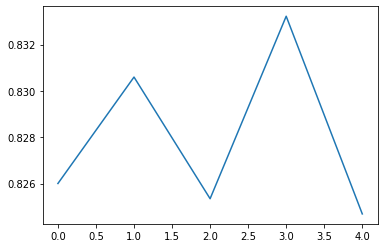

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_accuracy'])

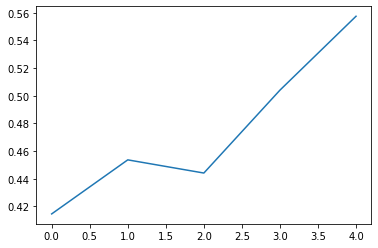

In [12]:
plt.plot(history.history['val_loss'])

In [13]:
electra_model = TFElectraModel.from_pretrained('google/electra-base-discriminator')

input_tokens = tf.keras.layers.Input(shape=(emb_len, ), name='tokens', dtype='int32')
input_masks = tf.keras.layers.Input(shape=(emb_len, ), name='masks', dtype='int32')

electra_output = electra_model(input_tokens, attention_mask=input_masks).last_hidden_state

x = tf.keras.layers.GlobalAveragePooling1D()(electra_output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(8, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
y = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs=[input_tokens, input_masks], outputs=y)
adam = tf.keras.optimizers.Adam(learning_rate=2e-5)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(x={'tokens':train_tokens, 'masks':train_masks}, y=labels, epochs=3, batch_size=16)

Epoch 1/3
476/476 [==============================] - 113s 238ms/step - loss: 0.4857 - accuracy: 0.7897
Epoch 2/3
476/476 [==============================] - 115s 242ms/step - loss: 0.3955 - accuracy: 0.8479
Epoch 3/3
476/476 [==============================] - 114s 239ms/step - loss: 0.3399 - accuracy: 0.8717


In [14]:
# Apply Preprocssing to Test Data

test_data = pd.read_csv('test.csv')

test_data['text'] = test_data['text'].str.replace('http\S+', 'http', regex=True)
test_data['text'] = test_data['text'].str.replace('&\S+', '', regex=True)
test_data['text'] = test_data['text'].str.replace('[0-9]','0', regex=True)
test_data['text'] = test_data['text'].str.replace('[^a-zA-Z0 ]', '', regex=True)
test_data['text'] = test_data['text'].str.lower()

test_texts = test_data['text'].tolist()

print(emb_len)
test_texts = tokenizer(test_texts, truncation=True, padding='max_length', max_length=emb_len)
test_tokens = np.asarray(test_texts['input_ids'])
test_masks = np.asarray(test_texts['attention_mask'])

print(test_tokens.shape)
print(test_masks.shape)

53
(3263, 53)
(3263, 53)


In [15]:
pred = model.predict(x={'tokens':test_tokens, 'masks':test_masks})
pred = np.asarray(np.rint(pred), dtype=int)
pred[:10]

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0]])

In [16]:
submission = pd.DataFrame()
submission['id'] = test_data['id']
submission['target'] = pred
submission.head(10)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [17]:
submission.to_csv('submission7-2.csv', index=False)
# Accuracy Score : 0.83879